Best k: 12
Best distance metric: manhattan
Accuracy on test set: 0.958041958041958
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        53
           1       0.97      0.97      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



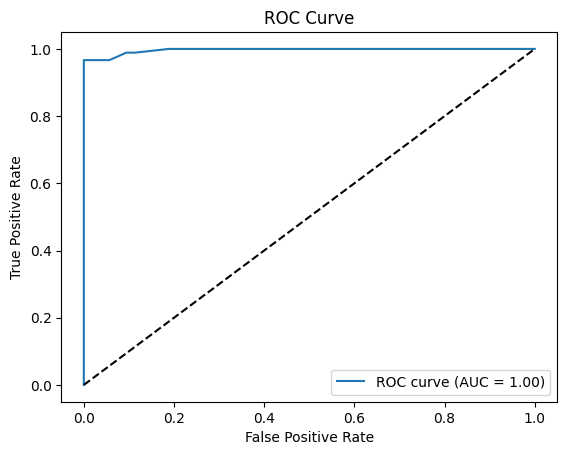

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the breast cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_neighbors': range(1, 21), 'metric': ['euclidean', 'manhattan', 'chebyshev']}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']

# Train the final k-NN model using the best hyperparameters
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn_final.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set and generate a classification report
y_pred = knn_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Best k: {best_k}")
print(f"Best distance metric: {best_metric}")
print(f"Accuracy on test set: {accuracy}")
print("Classification Report:")
print(report)

# Generate and plot the ROC curve
y_prob = knn_final.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Optimal k: 12
Optimal distance metric: euclidean
Accuracy on test set: 0.951048951048951


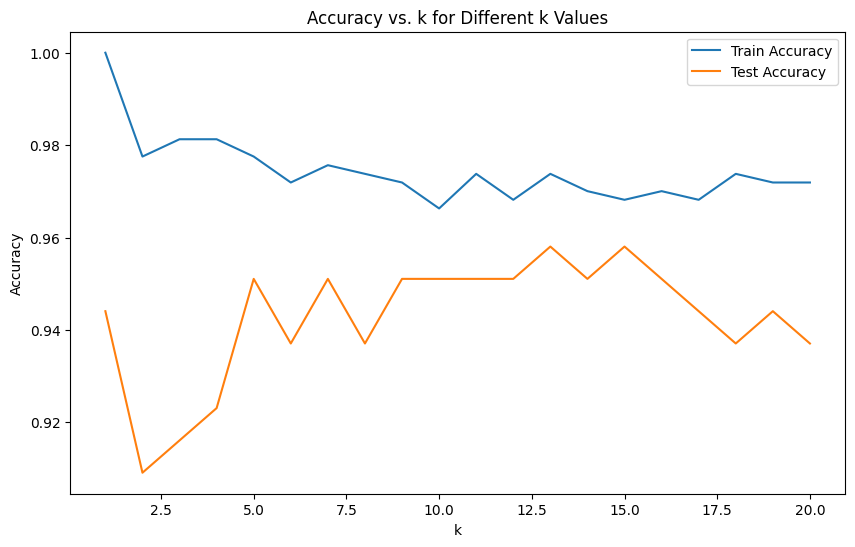

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the breast cancer dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a function to perform cross-validation and return the mean accuracy
def cross_val_mean_knn(k, metric='euclidean'):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    return np.mean(cv_scores)

# Choose the optimal k value using cross-validation
k_values = range(1, 21)
mean_cv_scores = [cross_val_mean_knn(k) for k in k_values]
optimal_k = k_values[np.argmax(mean_cv_scores)]

# Choose the optimal distance metric
metrics = ['euclidean', 'manhattan', 'chebyshev']
mean_cv_scores_metrics = {metric: cross_val_mean_knn(optimal_k, metric) for metric in metrics}
optimal_metric = max(mean_cv_scores_metrics, key=mean_cv_scores_metrics.get)

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the final k-NN model using the optimal k and distance metric
knn_final = KNeighborsClassifier(n_neighbors=optimal_k, metric=optimal_metric)
knn_final.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred = knn_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimal k: {optimal_k}")
print(f"Optimal distance metric: {optimal_metric}")
print(f"Accuracy on test set: {accuracy}")

# Fit the model for different k values and plot the results
train_scores = []
test_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric=optimal_metric)
    knn.fit(X_train_resampled, y_train_resampled)
    train_scores.append(knn.score(X_train_resampled, y_train_resampled))
    test_scores.append(knn.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, label='Train Accuracy')
plt.plot(k_values, test_scores, label='Test Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Different k Values')
plt.legend()
plt.show()
